In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

# Code focuses on 5 bright sources that are visible in both the VLA and Meerkat (MKT) data
# We do this to check if the observations from the Q and U channels match between these telescopes
# For this we have two methods. We can compare flux measurements from Meerkat with the fluxes that
# Erik measured with his flux measurement method and my method. In principle, we would expect these
# to be the same within error margins, since we both used aperture photometry on the same data.
# However, I will use the same physical aperture size on both Meerkat and VLA data where Erik might
# have used a different size. If this matches somewhat with Meerkat data, we can safely assume that
# the MKT data is not dominated by leakage or other systematic errors.

In [45]:
#We first import MKT datacubes in all channels (I,Q,U,V)
directory = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85\\'
directory_univ = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'

I_hdu_old = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]

I_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_I_Farcsec_fcube_cor.smoothed.fits'))[0]
I_header = I_hdu.header
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_Q_Farcsec_fcube_cor.smoothed.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_U_Farcsec_fcube_cor.smoothed.fits'))[0]
U_cube = U_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)

I_wcs = WCS(I_hdu_old.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)


# We then define variables containing the subband frequencies
# Carefull: central frequencies in DR1 paper are wrong
freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]
    
np.save('MKT_Freqs_low.npy', freqs_lower)
np.save('MKT_Freqs_mid.npy', freqs_middle)
np.save('MKT_Freqs_up.npy', freqs_upper)

In [12]:
# We calculate the linpol intensity cube and the freqmean and save the cube.
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto(directory + r'\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

In [13]:
# We perform some preparatory work for flux measurements.
# First step is finding the sources.
# The background statistics are found using sigma clipping.
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

# We then define where we are going to look for, the criteria.
daofind = DAOStarFinder(fwhm=3.0, threshold=3.5*backgr_std)
mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
#These masks ensure we only select the five sources we want to compare with VLA
mask[1600:1700, 1250:1350] = False
mask[1100:1200, 1500:1600] = False
mask[1300:1500, 1200:1400] = False

# We then do the actual sourcefinding
sources_compar = daofind(linpol_intens_freqmean - backgr_median, mask=mask) # Median instead of mean to be less depend on outliers
# And we prepare the apertures:
positions_compar = np.transpose((sources_compar['xcentroid'], sources_compar['ycentroid']))
apertures_compar = CircularAperture(positions_compar, r=7.)
annulus_aperture = CircularAnnulus(positions_compar, r_in=30, r_out=40)

for col in sources_compar.colnames:
    sources_compar[col].info.format = '%.8g'  # for consistent table output

# This also gives some flux results, but this doesn't take beamsize/pix into account
print(sources_compar)

(2.209594640589785e-05, 2.075688826153055e-05, 7.2467964855604805e-06)
 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag     
--- --------- --------- ---------- ... --- ------------- --------- ------------
  1 1574.1811 1124.9373 0.39497672 ...   0 0.00090680679 8.5093737    -2.324744
  2 1564.5927 1137.3191 0.39689584 ...   0 0.00016966261 1.6554674  -0.54730157
  3 1560.7177 1142.0528 0.39392111 ...   0 0.00036715681 3.4682154   -1.3502652
  4 1356.0674 1404.5073 0.39286682 ...   0 0.00011533114   1.06267 -0.065996031
  5  1290.962 1658.5418 0.39503746 ...   0  0.0015224456 14.142614   -2.8763243


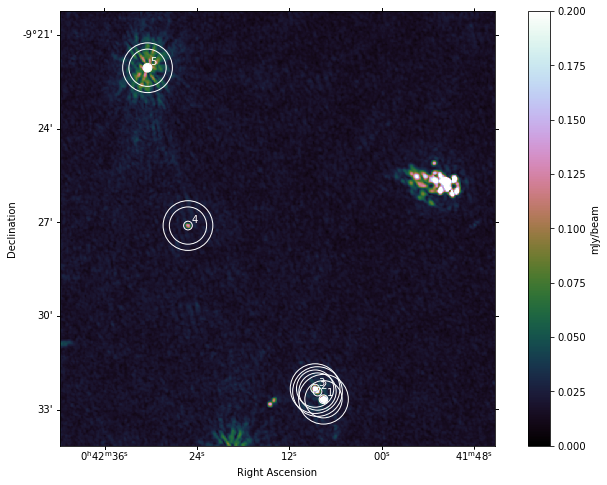

In [91]:
# We plot the selected sources with their apertures on the Meerkat data

plt.figure(figsize=(12,8))
plt.title('Apertures of selected sources plotted on linpol intensity')
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(1e3*linpol_intens_freqmean, cmap='cubehelix', vmin=0, vmax=0.2\
                  , origin='lower', interpolation='nearest')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.colorbar(map1, label='mJy/beam')
plt.ylim(1050,1750)
plt.xlim(1150,1850)
apertures_compar.plot(color='white', lw=1)
annulus_aperture.plot(color='white', lw=1, label='Background annulus')
for n in range(5):
    plt.text(sources_compar['xcentroid'][n]+5, sources_compar['ycentroid'][n]+5, sources_compar['id'][n], color='white')
plt.savefig('ACO85_Linpol_Freqmean_Aperscompar.pdf', dpi=300)

In [15]:
# We perform flux measurements:

FWHM_major_axis = 2.327777777632E-03*c.degree# 2.140979E-03*c.degree # Information from the header
FWHM_minor_axis = 2.327777777632E-03*c.degree# 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
delta_cal = 0.05
N = 1

def photometry(data_local, apers_local, annulus_local, psize, min_ax, maj_ax, n, delta_cal=0.05, N=1):
    # This function calculates the flux from a source
    data_local_intensity = data_local*4*np.log(2)/(np.pi*maj_ax*min_ax) # Converts Jy/beam to Jy/sr
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    flux = phot_table['aperture_sum']*(psize**2)
    annulus_masks = annulus_local.to_mask()
    backgr_error = np.zeros(n)
    for i in range(n):
        annulus_data = annulus_masks[i].multiply(data_local)
        annulus_data_1d = annulus_data[annulus_masks[i].data != 0.]
        backgr_error[i] = np.std(annulus_data_1d) # error per beam due to background
    flux_error = np.sqrt((backgr_error*np.sqrt(N))**2 + (delta_cal*flux)**2)
    phot_table['flux'] = flux
    phot_table['flux_err'] = flux_error
    return phot_tablef

phot_table_compar = photometry(I_freqmean, apertures_compar, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources_compar))
print(phot_table_compar)

 id      xcenter       ...         flux                flux_err      
           pix         ...                                           
--- ------------------ ... -------------------- ---------------------
  1 1574.1811405256283 ... 0.020854289608351687 0.0010431082774675377
  2  1564.592694890947 ... 0.014141231080664153 0.0007074080056483717
  3 1560.7176851706251 ... 0.015053376347728893 0.0007544370754175382
  4 1356.0673532945575 ... 0.004411395121980468 0.0002206899823828909
  5 1290.9620488790451 ...  0.08871453850932413  0.004435779807542242


In [16]:
# Flux measurements are performed in all channels and saved in tables
I_phot_table_compar, I_phot_table_compar_err = np.zeros((12, len(sources_compar))), np.zeros((12, len(sources_compar)))
Q_phot_table_compar, Q_phot_table_compar_err = np.zeros((12, len(sources_compar))), np.zeros((12, len(sources_compar)))
U_phot_table_compar, U_phot_table_compar_err = np.zeros((12, len(sources_compar))), np.zeros((12, len(sources_compar)))
V_phot_table_compar, V_phot_table_compar_err = np.zeros((12, len(sources_compar))), np.zeros((12, len(sources_compar)))


for n in range(12):
    I_slice_phot_compar = photometry(I_cube[n], apertures_compar, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources_compar))
    Q_slice_phot_compar = photometry(Q_cube[n], apertures_compar, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources_compar))
    U_slice_phot_compar = photometry(U_cube[n], apertures_compar, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources_compar))
    V_slice_phot_compar = photometry(V_cube[n], apertures_compar, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources_compar))

    for i in range(len(sources_compar)):
        I_phot_table_compar[n, i], I_phot_table_compar_err[n, i] = I_slice_phot_compar[i]['flux'], I_slice_phot_compar[i]['flux_err']
        Q_phot_table_compar[n, i], Q_phot_table_compar_err[n, i] = Q_slice_phot_compar[i]['flux'], Q_slice_phot_compar[i]['flux_err']
        U_phot_table_compar[n, i], U_phot_table_compar_err[n, i] = U_slice_phot_compar[i]['flux'], U_slice_phot_compar[i]['flux_err']
        V_phot_table_compar[n, i], V_phot_table_compar_err[n, i] = V_slice_phot_compar[i]['flux'], V_slice_phot_compar[i]['flux_err']

# The linear polarization intensity and angles are also calculated:
Pol_Angles_compar = 0.5*np.arctan2(U_phot_table_compar, Q_phot_table_compar)
Linpol_compar = np.sqrt(U_phot_table_compar**2 + Q_phot_table_compar**2)
Linpol_compar_err = (U_phot_table_compar*U_phot_table_compar_err + Q_phot_table_compar*Q_phot_table_compar_err)/Linpol_compar

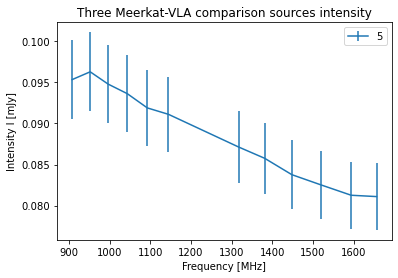

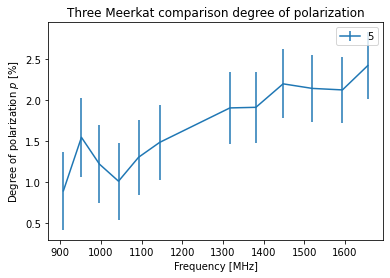

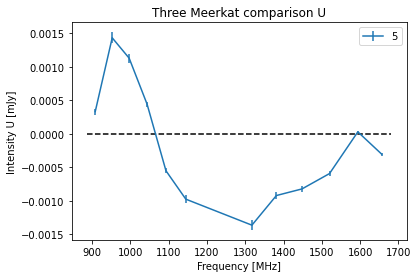

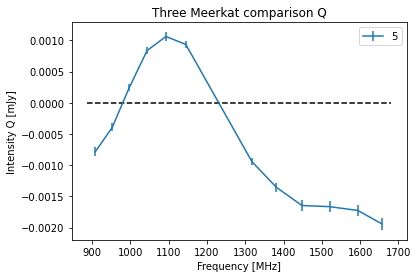

[-0.20000434 -0.65107255  0.68060976  0.24317404 -0.23985343 -0.40350787
  0.48331742  0.29880017  0.23199462  0.17143878 -0.0084725   0.07776832]


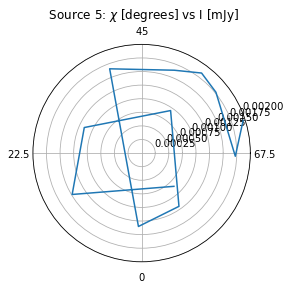

In [74]:
# The results from this photometry are plotted:
Labels = ['1', '2', '3', '4', '5']

plt.title('Three Meerkat-VLA comparison sources intensity')
plt.errorbar(freqs_middle/1e6, I_phot_table_compar[:,4], yerr=I_phot_table_compar_err[:,4], label=Labels[4])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison degree of polarization')
plt.errorbar(freqs_middle/1e6, 100*Linpol_compar[:,4]/I_phot_table_compar[:,4], yerr=100*np.sqrt(Linpol_compar_err[:,4]**2+I_phot_table_compar_err[:,4]**2), label=Labels[4])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison U')
plt.errorbar(freqs_middle/1e6, U_phot_table_compar[:,4], yerr=U_phot_table_compar_err[:,4], label=Labels[4])
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat comparison Q')
plt.errorbar(freqs_middle/1e6, Q_phot_table_compar[:,4], yerr=Q_phot_table_compar_err[:,4], label=Labels[4])
plt.hlines(0, min(freqs_lower)/1e6, max(freqs_upper)/1e6, color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.legend()
plt.show()

print(Pol_Angles_compar[:,4])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_compar[:,4], Linpol_compar[:,4])
ax.set_rmax(0.002)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 5: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [18]:
# Next, the flux measurements are loaded from VLA data by Erik, both the values and errors:
Freqs_VLA = np.loadtxt(r'/net/vdesk/data2/GoesaertW/VLA_Data/lambda_squared.txt', dtype=float)[:,1]*1e9

I_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA = np.zeros((len(Freqs_VLA),5))
I_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
Q_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))
U_phot_table_VLA_err = np.zeros((len(Freqs_VLA),5))

fname_pt1 = r'/net/vdesk/data2/GoesaertW/VLA_Data/Abell_85_photometry'
fname_pt2 = r'/Stokes_'
fname_pt3 = r'cor_source_'
fname_pt4 = r'_unc_source_'

for n in range(5):
    # We do 4-n because the number of the 5 sources in Eriks data is exactly opposite to ours
    I_phot_table_VLA[:,n] = np.load(fname_pt1+fname_pt2+'I/StokesI'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA[:,n] = np.load(fname_pt1+fname_pt2+'Q/StokesQ'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    U_phot_table_VLA[:,n] = np.load(fname_pt1+fname_pt2+'U/StokesU'+fname_pt3+str(4-n)+'.npy', allow_pickle=True)
    I_phot_table_VLA_err[:,n] = np.load(fname_pt1+fname_pt2+'I/StokesI'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)
    Q_phot_table_VLA_err[:,n] = np.load(fname_pt1+fname_pt2+'Q/StokesQ'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)
    U_phot_table_VLA_err[:,n] = np.load(fname_pt1+fname_pt2+'U/StokesU'+fname_pt4+str(4-n)+'.npy', allow_pickle=True)

# The linear polarization intensity and angles are also calculated for VLA:
Pol_Angles_VLA = 0.5*np.arctan(U_phot_table_VLA/Q_phot_table_VLA)
Linpol_VLA = np.sqrt(U_phot_table_VLA**2 + Q_phot_table_VLA**2)
Linpol_VLA_err = (U_phot_table_VLA*U_phot_table_VLA_err + Q_phot_table_VLA*Q_phot_table_VLA_err)/Linpol_VLA

print(np.shape(I_phot_table_VLA))
print(np.shape(I_phot_table_VLA_err))

(90, 5)
(90, 5)


In [19]:
# The fluxmeasurements from Erik are plotted next to our own

# Because we will compare results regularly between MKT and VLA, let's define a function:
def plotter(freqs_1, freqs_2, I_1, I_2, I_1_err, I_2_err, Q_1, Q_2, Q_1_err, Q_2_err, U_1, U_2, U_1_err, U_2_err\
            , Linpol_1, Linpol_1_err,Linpol_2, Linpol_2_err, Pol_Angles_1, Pol_Angles_2,  labels, name_1, name_2\
            , channels, polar, angle, statistic):
    
    # This function takes all data from two sets of photometry data to be compared and plots both
    # Remove 4- everywhere by reversing array
    if channels:
        for n in range(len(sources_compar)):
            fig, axs = plt.subplots(2, 2)
            fig.set_size_inches(12, 10)
            fig.tight_layout(pad=4.5)

            fig.suptitle('Comparison between two kinds of data (General plotting function)')
            axs[0,0].errorbar(freqs_1/1e6, I_1[:,n], yerr=I_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[0,0].errorbar(freqs_2/1e6, I_2[:,n], yerr=I_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[0,0].set_title('Intensity vs Frequency')
            axs[0,0].set_xlabel('Frequency [MHz]')
            axs[0,0].set_ylabel('Intensity I [mJy]')
            axs[0,0].legend()

            axs[0,1].errorbar(freqs_1/1e6, 100*Linpol_1[:,n]/I_1[:,n], yerr=Linpol_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[0,1].errorbar(freqs_2/1e6, 100*Linpol_2[:,n]/I_2[:,n], yerr=Linpol_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[0,1].set_title('Degree of polarization')
            axs[0,1].set_xlabel('Frequency [MHz]')
            axs[0,1].set_ylabel('Degree of polarization $p$ [%]')
            axs[0,1].legend()

            axs[1,0].errorbar(freqs_1/1e6, Q_1[:,n], yerr=Q_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[1,0].errorbar(freqs_2/1e6, Q_2[:,n], yerr=Q_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[1,0].hlines(0, min(freqs_middle)/1e6, max(freqs_middle)/1e6, color='black', linestyle='dashed')
            axs[1,0].set_title('Intensity Q')
            axs[1,0].set_xlabel('Frequency [MHz]')
            axs[1,0].set_ylabel('Intensity Q [mJy]')
            axs[1,0].legend()

            axs[1,1].errorbar(freqs_1/1e6, U_1[:,n], yerr=U_1_err[:,n], label=labels[n] + name_1, color='red', marker='o')
            axs[1,1].errorbar(freqs_2/1e6, U_2[:,n], yerr=U_2_err[:,n], label=labels[n] + name_2, color='blue', marker='x')
            axs[1,1].hlines(0, min(freqs_1)/1e6, max(freqs_1)/1e6, color='black', linestyle='dashed')
            axs[1,1].set_title('Intensity U')
            axs[1,1].set_xlabel('Frequency [MHz]')
            axs[1,1].set_ylabel('Intensity U [mJy]')
            axs[1,1].legend()

            plt.show()

    if polar:
        for n in range(len(sources_compar)):
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
            fig.set_size_inches(8, 8)
            ax.plot(4*Pol_Angles_1[:,n], I_1[:,n],color='red', marker='o', label=labels[n] + name_1)
            ax.plot(4*Pol_Angles_2[:,n], I_2[:,n],color='blue', marker='x', label=labels[n] + name_2)
        #    ax.set_rmax(1.1*np.max(I_hist_VLA[:,n]))
            ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
            ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
            ax.grid(True)
            ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs I [mJy]")
            ax.legend()
            plt.show()

    if angle:
        for n in range(len(sources_compar)):
            plt.figure(figsize=(8,6))
            plt.plot(freqs_1/1e6, Pol_Angles_1[:,n], color='red', marker='o', label=labels[n] + name_1)
            plt.plot(freqs_2/1e6, Pol_Angles_2[:,n], color='blue', marker='x', label=labels[n] + name_2)
            plt.xlabel('Frequency [MHz]')
            plt.ylabel('Angle [Deg]')
            plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
            plt.legend()
            plt.show()

    if statistic:
        colors=['red','orange','green','blue','purple']
        for n in range(5):
            plt.scatter(I_1[:,n], I_2[:,n], color=colors[n])
        plt.title('Correlation I intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'I [mJy]')
        plt.ylabel(name_2+'I [mJy]')
        plt.show()
        for n in range(5):
            plt.scatter(Q_1[:,n], Q_2[:,n], color=colors[n])
        plt.title('Correlation Q intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'Q [mJy]')
        plt.ylabel(name_2+'Q [mJy]')
        plt.show()
        for n in range(5):
            plt.scatter(U_1[:,n], U_2[:,n], color=colors[n])
        plt.title('Correlation U intensity')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(name_1+'U [mJy]')
        plt.ylabel(name_2+'U [mJy]')
        plt.show()

# We trigger the plotter function:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_phot_table_compar, I_phot_table_VLA_err, I_phot_table_compar_err, Q_phot_table_VLA, Q_phot_table_compar, Q_phot_table_VLA_err, Q_phot_table_compar_err, U_phot_table_VLA, U_phot_table_compar, U_phot_table_VLA_err, U_phot_table_compar_err, Linpol_VLA, Linpol_VLA_err, Linpol_compar, Linpol_compar_err, Pol_Angles_VLA, Pol_Angles_compar, Labels, name_1='VLA', name_2='MKT', channels=False, polar=False, angle=False, statistic=False)

In [20]:
# In order to evaluate the data from Meerkat and the VLA at the same frequencies in the same subbands
# we can bin the data according to the subbands from MKT. This is possible because the VLA has much more
# frequency planes (90) and thus each bin will contain enough VLA planes

# We first define the bin edges. We do this in two parts because the MKT data has a hole in the freqs due to interference
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

# We prepare arrays to be filled with binned data:
I_hist_VLA, Q_hist_VLA, U_hist_VLA = np.zeros((12,5)), np.zeros((12,5)), np.zeros((12,5))
I_hist_VLA_err, Q_hist_VLA_err, U_hist_VLA_err = np.zeros((12,5)), np.zeros((12,5)), np.zeros((12,5))

def binner(freqs, phot, stat):
    # This binner works in two seperate steps because our Meerkat data has a hole in the freqs
    hist_1,_,_ = stats.binned_statistic(freqs, phot, statistic=stat, bins=bins_VLA_1)
    hist_2,_,_ = stats.binned_statistic(freqs, phot, statistic=stat, bins=bins_VLA_2)
    return np.append(hist_1, hist_2)

# Binning is performed for all 5 sources:
for n in range(5):
    I_hist_VLA[:,n] = binner(Freqs_VLA, I_phot_table_VLA[:,n], 'mean')
    I_hist_VLA_err[:,n] = binner(Freqs_VLA, I_phot_table_VLA[:,n], 'std')

    Q_hist_VLA[:,n] = binner(Freqs_VLA, Q_phot_table_VLA[:,n], 'mean')
    Q_hist_VLA_err[:,n] = binner(Freqs_VLA, Q_phot_table_VLA[:,n], 'std')

    U_hist_VLA[:,n] = binner(Freqs_VLA, U_phot_table_VLA[:,n], 'mean')
    U_hist_VLA_err[:,n] = binner(Freqs_VLA, U_phot_table_VLA[:,n], 'std')

# We also calculate the linpol intensity and angles
Pol_Angles_VLA_hist = 0.5*np.arctan(U_hist_VLA/Q_hist_VLA)
Linpol_VLA_hist = np.sqrt(U_hist_VLA**2 + Q_hist_VLA**2)
Linpol_VLA_hist_err = (U_hist_VLA*U_hist_VLA_err + Q_hist_VLA*Q_hist_VLA_err)/Linpol_VLA_hist

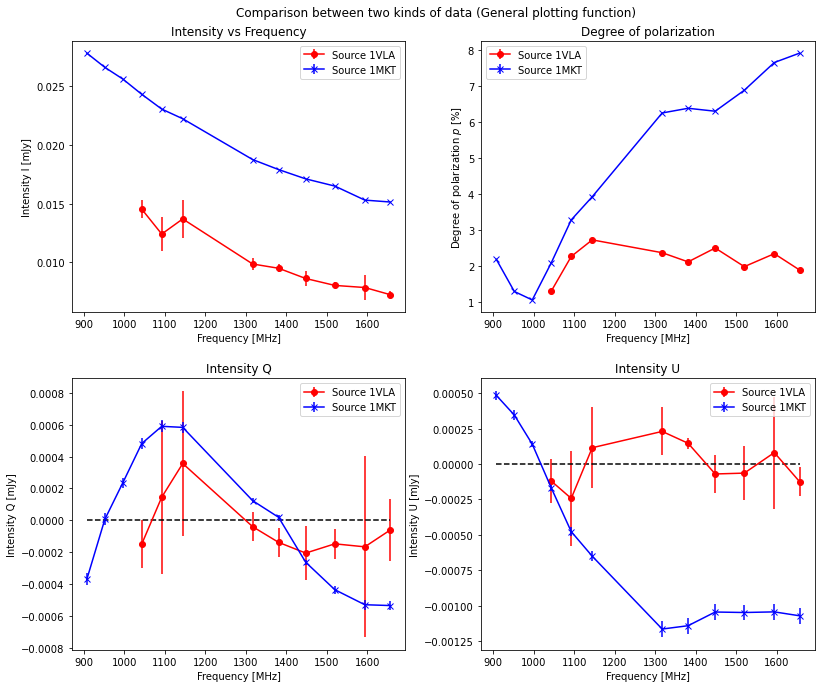

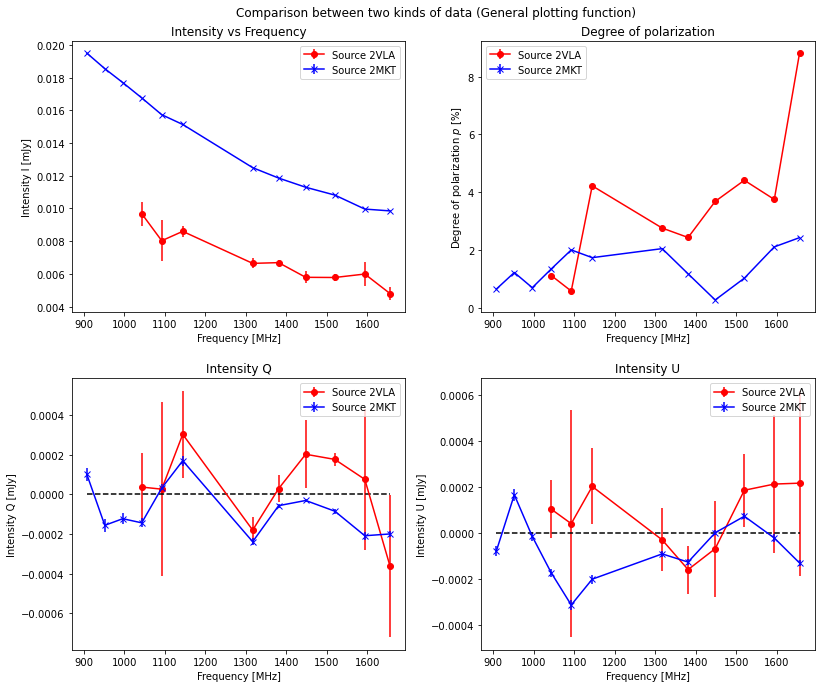

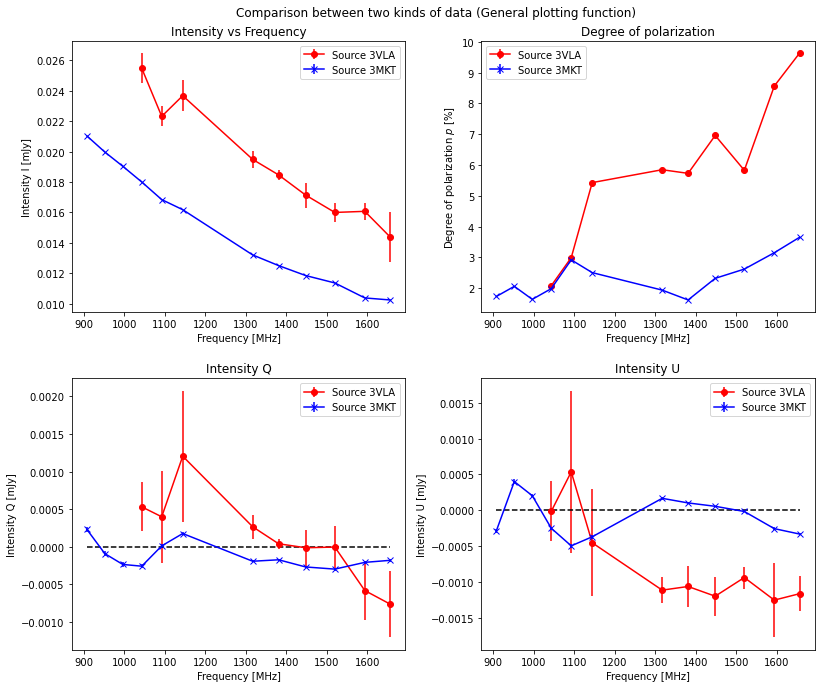

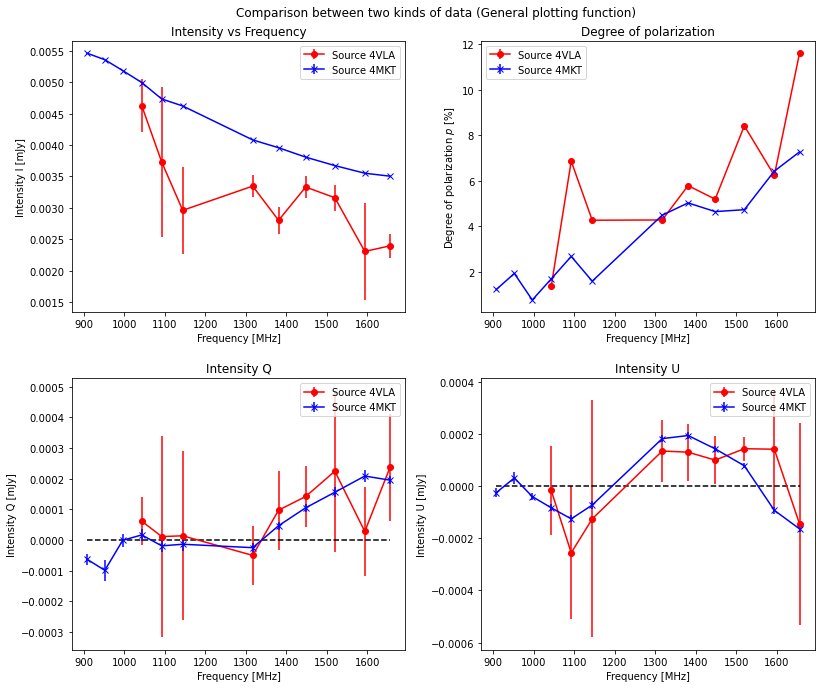

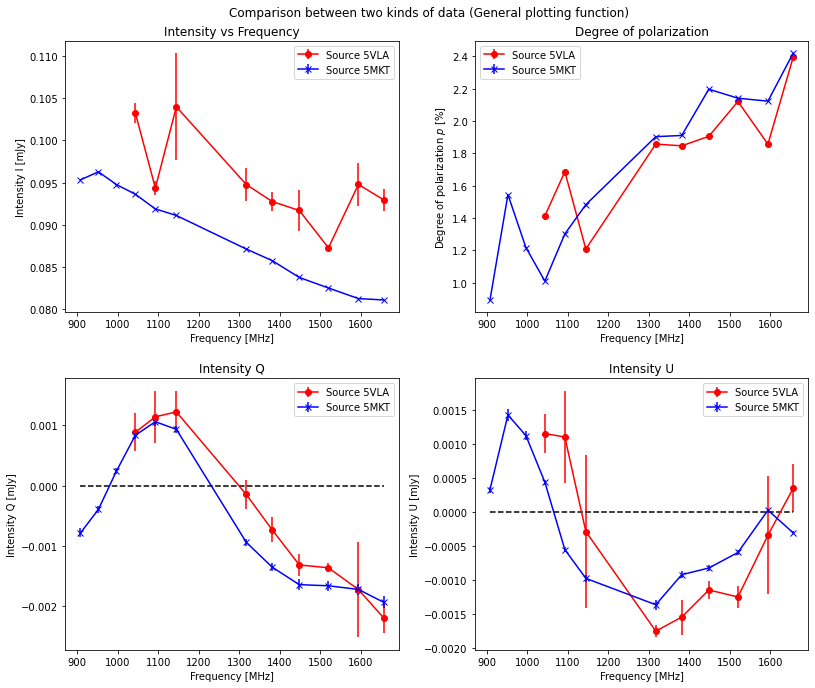

In [21]:
# We plot the results from the binning of Eriks flux measurements
plotter(freqs_middle, freqs_middle, I_hist_VLA, I_phot_table_compar, I_hist_VLA_err, np.zeros(np.shape(I_phot_table_compar)), Q_hist_VLA, Q_phot_table_compar, Q_hist_VLA_err, Q_phot_table_compar_err, U_hist_VLA, U_phot_table_compar, U_hist_VLA_err, U_phot_table_compar_err, Linpol_VLA_hist, Linpol_VLA_hist_err, Linpol_compar, Linpol_compar_err, Pol_Angles_VLA_hist, Pol_Angles_compar, Labels, name_1='VLA', name_2='MKT', channels=True, polar=False, angle=False, statistic=False)

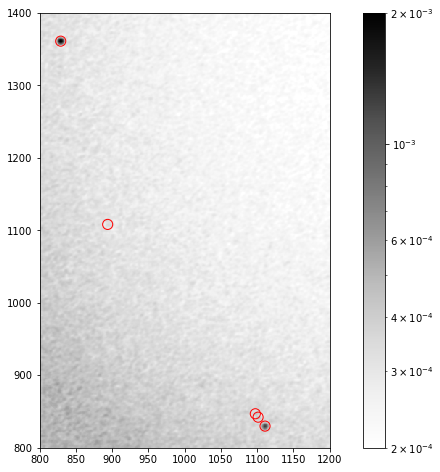

In [46]:
# Next step is to try to measure the flux in the VLA data ourselves
dir_VLA = r'/net/vdesk/data2/GoesaertW/VLA_Data/Abell_85_channels'
fname_pt2 = r'-image.pbcor.smoothed.fits'

# We get lots of useless warnings useless accoring to internet, so we turn this off (warning type: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57066.880035 from DATE-OBS'. [astropy.wcs.wcs] WARNING: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to -107.618000 from OBSGEO-[XYZ]. Set OBSGEO-B to 34.078827 from OBSGEO-[XYZ]. Set OBSGEO-H to 2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs])
import warnings
warnings.filterwarnings("ignore")

# We used a seperate notebook to make a freqmean linpol image of VLA data,
# which is usefull to see if our apertures match the data from VLA.
# This is because it is always possible that the VLA or Meerkat has significant pointing errors
Fits_Linpol_VLA_hdu = fits.open(get_pkg_data_filename(dir_VLA + r'/Abell_85_VLA_Linpol_Freqmean.fits'))
Fits_Linpol_VLA = Fits_Linpol_VLA_hdu[0].data.squeeze()

# Prepare for apers and flux measurement:
pixsize_VLA = 3.333333333333E-04*c.degree # All taken from header
FWHM_major_axis_VLA = 2.327777777795E-03*c.degree
FWHM_minor_axis_VLA = 2.327777776737E-03*c.degree
Aperturesize_VLA = 7*pixsize/pixsize_VLA
annulus_inner_VLA = 30*pixsize/pixsize_VLA
annulus_outer_VLA = 40*pixsize/pixsize_VLA
plot_VLA_apers = True

I_phot_table_VLA_own, I_phot_table_VLA_own_err = np.zeros((90, len(sources_compar))), np.zeros((90, len(sources_compar)))
Q_phot_table_VLA_own, Q_phot_table_VLA_own_err = np.zeros((90, len(sources_compar))), np.zeros((90, len(sources_compar)))
U_phot_table_VLA_own, U_phot_table_VLA_own_err = np.zeros((90, len(sources_compar))), np.zeros((90, len(sources_compar)))

# We measure the flux for each frequency and save it:
for n in range(90):
    # Fits images are loaded
    fname_pt1 = r'G115.16-72.09_'+(4-len(str(n)))*'0'+str(n)

    I_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '/stokes_i/' + fname_pt1+fname_pt2))
    I_plane = I_hdu[0].data.squeeze() # drops the size-1 axes
    I_header_VLA = I_hdu[0].header
    I_wcs_VLA = wcs.WCS(I_header_VLA).celestial
    I_new_header = I_wcs_VLA.to_header()
    
    Q_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '/stokes_q/' + fname_pt1+r'-Q'+fname_pt2))
    Q_plane = Q_hdu[0].data.squeeze() # drops the size-1 axes
    Q_header = Q_hdu[0].header
    Q_wcs_VLA = wcs.WCS(Q_header).celestial
    Q_new_header = Q_wcs_VLA.to_header()

    U_hdu = fits.open(get_pkg_data_filename(dir_VLA+ '/stokes_u/' + fname_pt1+r'-U'+fname_pt2))
    U_plane = U_hdu[0].data.squeeze() # drops the size-1 axes
    U_header = U_hdu[0].header
    U_wcs_VLA = wcs.WCS(U_header).celestial
    U_new_header = U_wcs_VLA.to_header()

    if n == 0:
        # To select same regions in VLA, we need to convert pixel coords between MKT and VLA
        I_wcs_new = wcs.WCS(I_header).celestial
        positions_VLA = np.zeros(np.shape(positions_compar))

        for i in range(len(sources_compar)):
            sky = I_wcs_new.pixel_to_world(positions_compar[i,0],positions_compar[i,1])
            positions_VLA[i] = Q_wcs_VLA.world_to_pixel(sky)

        apertures_VLA = CircularAperture(positions_VLA, r=Aperturesize_VLA)
        annulus_aperture_VLA = CircularAnnulus(positions_compar, r_in=annulus_inner_VLA, r_out=annulus_outer_VLA)

        # To check if the aperture locations are well converted from MKT to VLA, we plot:
        if plot_VLA_apers:
            plt.figure(figsize=(12,8))
            #plt.subplot(projection=Q_wcs_VLA)
            plt.imshow(Fits_Linpol_VLA.clip(min=0.0002, max=0.002), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
            apertures_VLA.plot(color='red', lw=1)
            plt.colorbar()
            plt.xlim(800,1200)
            plt.ylim(800,1400)
            plt.savefig('Apertures_VLAdata.pdf')

    # Actual photometry is done
    I_slice_phot_VLA = photometry(I_plane, apertures_VLA, annulus_aperture_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA, len(sources_compar))
    Q_slice_phot_VLA = photometry(Q_plane, apertures_VLA, annulus_aperture_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA, len(sources_compar))
    U_slice_phot_VLA = photometry(U_plane, apertures_VLA, annulus_aperture_VLA, pixsize_VLA, FWHM_minor_axis_VLA, FWHM_major_axis_VLA, len(sources_compar))
    for i in range(len(sources_compar)):
        I_phot_table_VLA_own[n, i], I_phot_table_VLA_own_err[n,i] = I_slice_phot_VLA[i]['flux'], I_slice_phot_VLA[i]['flux_err']
        Q_phot_table_VLA_own[n, i], Q_phot_table_VLA_own_err[n,i] = Q_slice_phot_VLA[i]['flux'], Q_slice_phot_VLA[i]['flux_err']
        U_phot_table_VLA_own[n, i], U_phot_table_VLA_own_err[n,i] = U_slice_phot_VLA[i]['flux'], U_slice_phot_VLA[i]['flux_err']

    I_hdu.close()
    Q_hdu.close()
    U_hdu.close()

Pol_Angles_VLA_own = 0.5*np.arctan(U_phot_table_VLA_own/Q_phot_table_VLA_own)
Linpol_VLA_own = np.sqrt(U_phot_table_VLA_own**2 + Q_phot_table_VLA_own**2)
Linpol_VLA_own_err = (U_phot_table_VLA_own*U_phot_table_VLA_own_err + Q_phot_table_VLA_own*Q_phot_table_VLA_own_err)/Linpol_VLA_own

In [96]:
# Just like before, to compare apples to apples, we bin the resulting flux data:
bins_VLA_1 = np.append(freqs_lower[0], freqs_upper[:6])
bins_VLA_2 = np.append(freqs_lower[6:], freqs_upper[-1])

I_hist_VLA_own = np.zeros((12,5))
Q_hist_VLA_own = np.zeros((12,5))
U_hist_VLA_own = np.zeros((12,5))
I_hist_VLA_err_own = np.zeros((12,5))
Q_hist_VLA_err_own = np.zeros((12,5))
U_hist_VLA_err_own = np.zeros((12,5))

num_points_1,_,_ = stats.binned_statistic(Freqs_VLA, np.ones(len(I_phot_table_VLA_own[:,0])), statistic='sum', bins=bins_VLA_1)
num_points_2,_,_ = stats.binned_statistic(Freqs_VLA, np.ones(len(I_phot_table_VLA_own[:,0])), statistic='sum', bins=bins_VLA_2)
num_points = np.append(num_points_1, num_points_2)
print(num_points)

for n in range(5):
    I_hist_VLA_own[:,n] = binner(Freqs_VLA, I_phot_table_VLA_own[:,n], 'mean')
    I_hist_VLA_err_own[:,n] = np.sqrt((binner(Freqs_VLA, I_phot_table_VLA_own[:,n],'std')/np.sqrt(num_points))**2+(I_hist_VLA_own[:,n]*0.05)**2)
    Q_hist_VLA_own[:,n] = binner(Freqs_VLA, Q_phot_table_VLA_own[:,n], 'mean')
    Q_hist_VLA_err_own[:,n] = np.sqrt((binner(Freqs_VLA, Q_phot_table_VLA_own[:,n],'std')/np.sqrt(num_points))**2+(Q_hist_VLA_own[:,n]*0.05)**2)
    U_hist_VLA_own[:,n] = binner(Freqs_VLA, U_phot_table_VLA_own[:,n], 'mean')
    U_hist_VLA_err_own[:,n] = np.sqrt((binner(Freqs_VLA, U_phot_table_VLA_own[:,n],'std')/np.sqrt(num_points))**2+(U_hist_VLA_own[:,n]*0.05)**2)

Pol_Angles_VLA_hist_own = 0.5*np.arctan(U_hist_VLA_own/Q_hist_VLA_own)
Linpol_VLA_hist_own = np.sqrt(U_hist_VLA_own**2 + Q_hist_VLA_own**2)
Linpol_VLA_hist_err_own = (U_hist_VLA_own*U_hist_VLA_err_own + Q_hist_VLA_own*Q_hist_VLA_err_own)/Linpol_VLA_hist_own

[0. 0. 0. 6. 5. 5. 6. 6. 7. 3. 5. 4.]


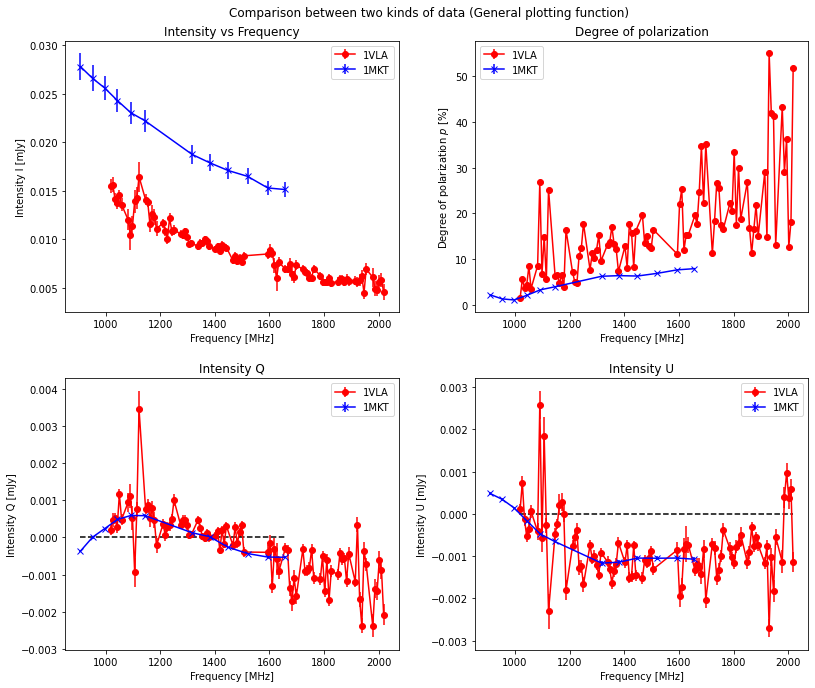

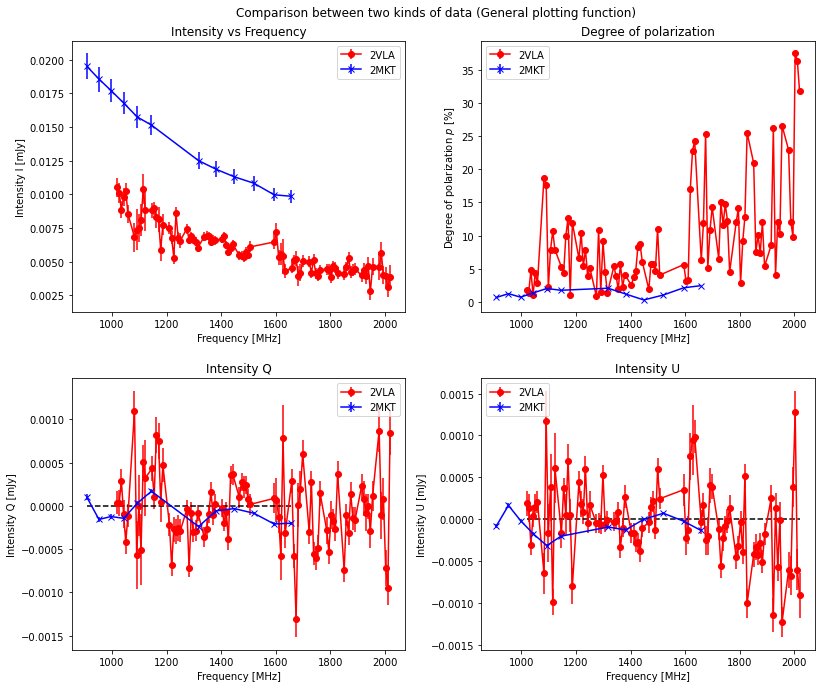

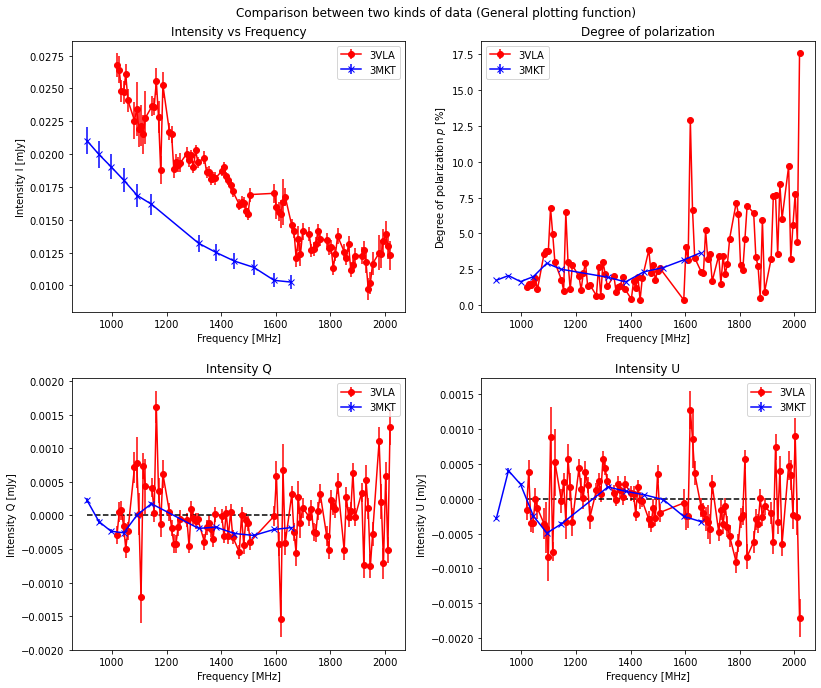

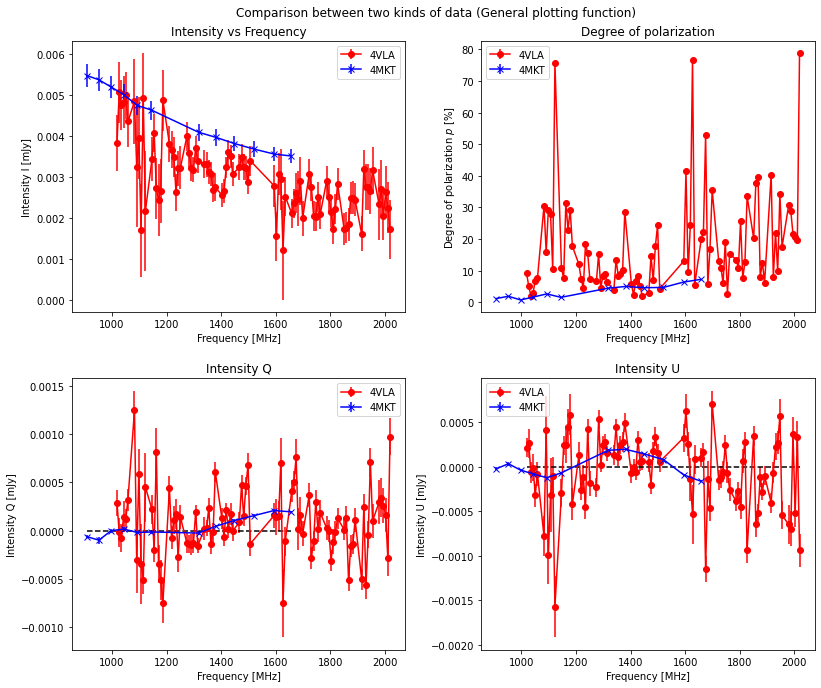

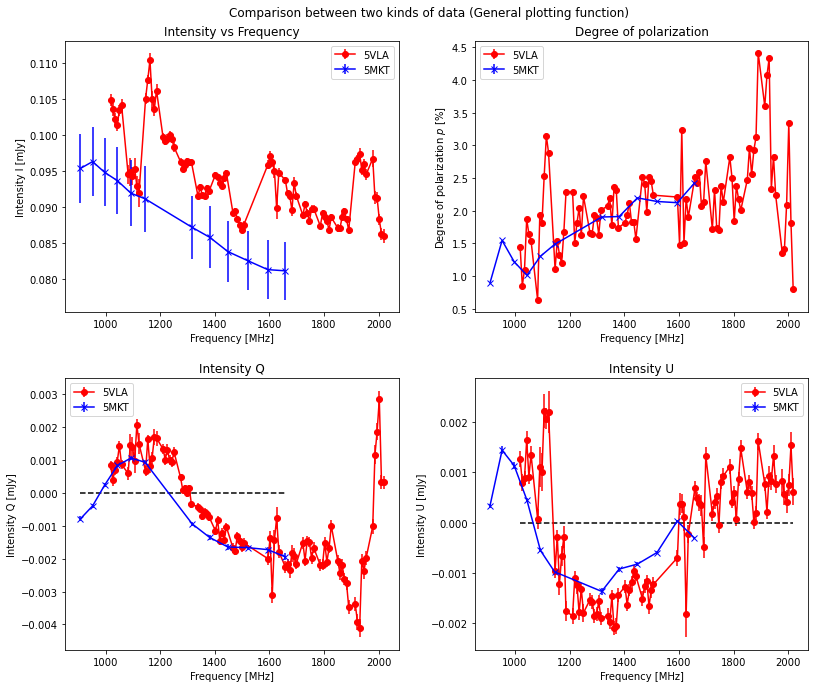

In [97]:
# Comparing our own unbinned VLA flux with MKT fluxes:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_phot_table_compar, I_phot_table_VLA_err\
        , I_phot_table_compar_err, Q_phot_table_VLA_own, Q_phot_table_compar, Q_phot_table_VLA_own_err\
        , Q_phot_table_compar_err, U_phot_table_VLA_own, U_phot_table_compar, U_phot_table_VLA_own_err\
        , U_phot_table_compar_err, Linpol_VLA_own, Linpol_VLA_own_err, Linpol_compar, Linpol_compar_err\
        , Pol_Angles_VLA_own, Pol_Angles_compar, Labels, name_1='VLA', name_2='MKT', channels=True, polar=False, angle=False, statistic=False)

# Comparing our own unbinned VLA flux with Eriks unbinned VLA fluxes:
plotter(Freqs_VLA, Freqs_VLA, I_phot_table_VLA, I_phot_table_VLA, I_phot_table_VLA_err, I_phot_table_VLA_err, Q_phot_table_VLA, Q_phot_table_VLA_own, Q_phot_table_VLA_err, U_phot_table_VLA_own_err, U_phot_table_VLA, U_phot_table_VLA_own, U_phot_table_VLA_err, U_phot_table_VLA_own_err, Linpol_VLA, Linpol_VLA_err, Linpol_VLA_own, Linpol_VLA_own_err, Pol_Angles_VLA, Pol_Angles_VLA_own, Labels, name_1='VLA Erik', name_2='VLA Own', channels=False, polar=False, angle=False, statistic=False)

# Comparing eriks unbinned VLA fluxes with eriks binned VLA fluxes:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_hist_VLA, I_phot_table_VLA_err, I_hist_VLA_err, Q_phot_table_VLA, Q_hist_VLA, Q_phot_table_VLA_err, Q_hist_VLA_err, U_phot_table_VLA, U_hist_VLA, U_phot_table_VLA_err, U_hist_VLA_err, Linpol_VLA, Linpol_VLA_err, Linpol_VLA_hist, Linpol_VLA_hist_err, Pol_Angles_VLA, Pol_Angles_VLA_hist, Labels, name_1='VLA Erik', name_2='VLA Erik Binned', channels=False, polar=False, angle=False, statistic=False)

# Comparing own unbinned VLA fluxes with own binned VLA fluxes:
plotter(Freqs_VLA, freqs_middle, I_phot_table_VLA, I_hist_VLA, I_phot_table_VLA_err, I_hist_VLA_err, Q_phot_table_VLA_own, Q_hist_VLA_own, Q_phot_table_VLA_own_err, Q_hist_VLA_err_own, U_phot_table_VLA_own, U_hist_VLA_own, U_phot_table_VLA_own_err, U_hist_VLA_err_own, Linpol_VLA_own, Linpol_VLA_own_err, Linpol_VLA_hist_own, Linpol_VLA_hist_err_own, Pol_Angles_VLA_own, Pol_Angles_VLA_hist_own, Labels, name_1='VLA own unbinned', name_2='VLA own Binned', channels=False, polar=False, angle=False, statistic=False)

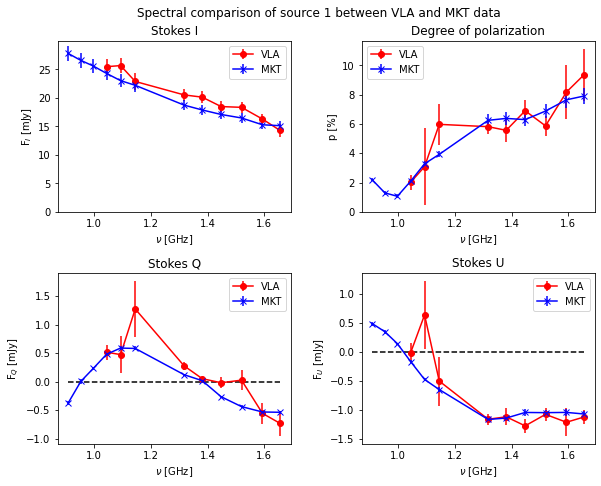

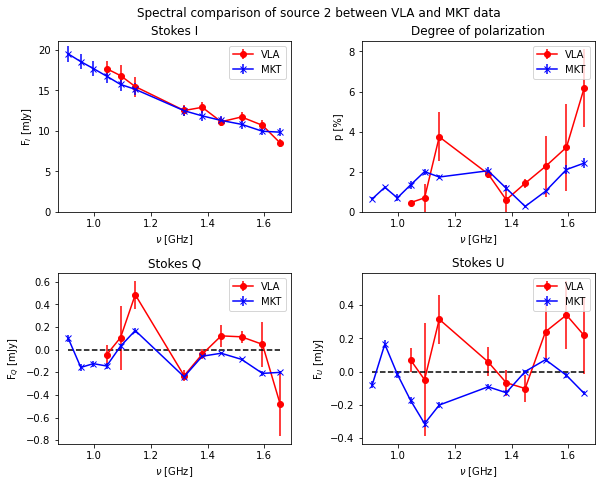

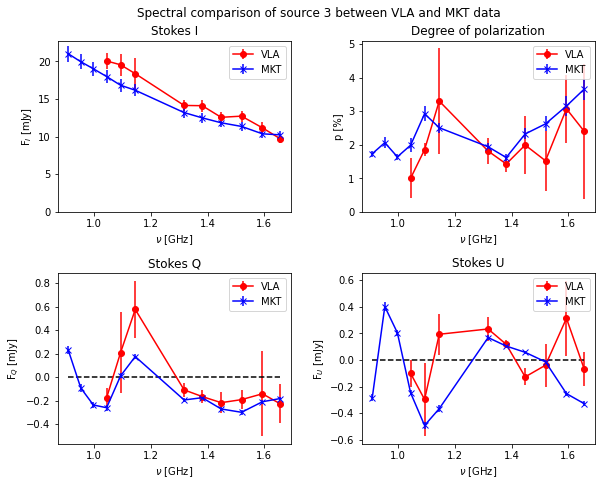

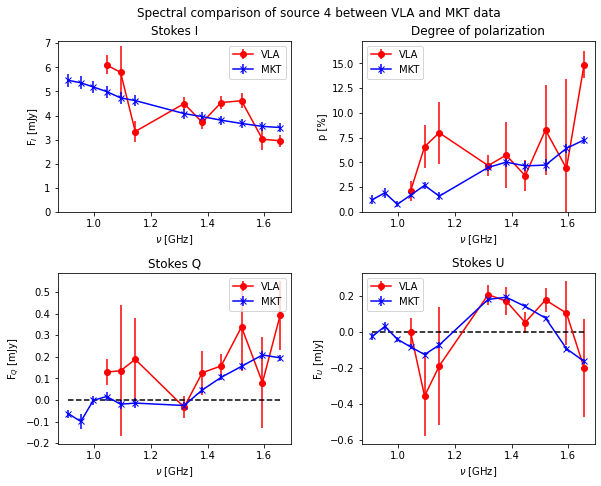

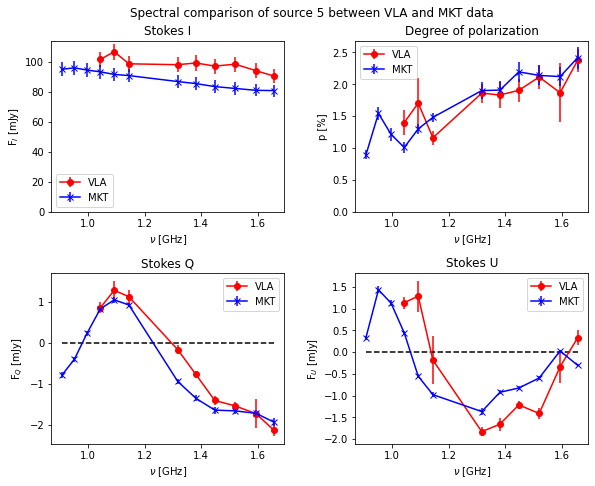

In [100]:
# To compare all three, MKT, Erik VLA flux and own VLA flux, we can't rely on plotting function

channels = True
polar = False
angle = False
statistic = False

polfrac_VLA = Linpol_VLA_hist_own/I_hist_VLA_own
polfrac_VLA_err = polfrac_VLA*np.sqrt((Linpol_VLA_hist_err_own/Linpol_VLA_hist_own)**2+(I_hist_VLA_err_own/I_hist_VLA_own)**2)

polfrac_MKT = Linpol_compar/I_phot_table_compar
polfrac_MKT_err = polfrac_MKT*np.sqrt((Linpol_compar_err/Linpol_compar)**2+(I_phot_table_compar_err/I_phot_table_compar)**2)


if channels:
    for n in range(5):
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(9, 7)
        fig.tight_layout(pad=4)

        fig.suptitle('Spectral comparison of source '+Labels[n]+' between VLA and MKT data')
        axs[0,0].errorbar(freqs_middle/1e9, 1e3*I_hist_VLA_own[:,n], yerr=1e3*I_hist_VLA_err_own[:,n], label='VLA', color='red', marker='o')
        axs[0,0].errorbar(freqs_middle/1e9, 1e3*I_phot_table_compar[:,n], yerr=1e3*I_phot_table_compar_err[:,n], label='MKT', color='blue', marker='x')
        axs[0,0].set_title('Stokes I')
        axs[0,0].set_xlabel(r'$\nu$ [GHz]')
        axs[0,0].set_ylabel('F$_I$ [mJy]')
        axs[0,0].set_ylim(bottom=0)
        axs[0,0].legend()

        axs[0,1].errorbar(freqs_middle/1e9, 100*polfrac_VLA[:,n], yerr=100*polfrac_VLA_err[:,n], label='VLA', color='red', marker='o')
#        axs[0,1].errorbar(freqs_middle/1e6, Linpol_VLA_hist[:,n], yerr=Linpol_VLA_hist_err[:,n], label=Labels[n] + ' VLA (Erik)', color='red', marker='o')
        axs[0,1].errorbar(freqs_middle/1e9, 100*polfrac_MKT[:,n], yerr=100*polfrac_MKT_err[:,n], label='MKT', color='blue', marker='x')
        axs[0,1].set_title('Degree of polarization')
        axs[0,1].set_xlabel(r'$\nu$ [GHz]')
        axs[0,1].set_ylabel('p [%]')
        axs[0,1].set_ylim(bottom=0)
        axs[0,1].legend()

        axs[1,0].errorbar(freqs_middle/1e9, 1e3*Q_hist_VLA_own[:,n], yerr=1e3*Q_hist_VLA_err_own[:,n], label='VLA', color='red', marker='o')
#        axs[1,0].errorbar(freqs_middle/1e6, Q_hist_VLA[:,n], yerr=Q_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,0].errorbar(freqs_middle/1e9, 1e3*Q_phot_table_compar[:,n], yerr=1e3*Q_phot_table_compar_err[:,n], label='MKT', color='blue', marker='x')
        axs[1,0].hlines(0, min(freqs_middle)/1e9, max(freqs_middle)/1e9, color='black', linestyle='dashed')
        axs[1,0].set_title('Stokes Q')
        axs[1,0].set_xlabel(r'$\nu$ [GHz]')
        axs[1,0].set_ylabel('F$_Q$ [mJy]')
        axs[1,0].legend()

        axs[1,1].errorbar(freqs_middle/1e9, 1e3*U_hist_VLA_own[:,n], yerr=1e3*U_hist_VLA_err_own[:,n], label='VLA', color='red', marker='o')
#        axs[1,1].errorbar(freqs_middle/1e6, U_hist_VLA[:,n], yerr=U_hist_VLA_err[:,n], label=Labels[n] + ' VLA (erik)', color='red', marker='o')
        axs[1,1].errorbar(freqs_middle/1e9, 1e3*U_phot_table_compar[:,n], yerr=1e3*U_phot_table_compar_err[:,n], label='MKT', color='blue', marker='x')
        axs[1,1].hlines(0, min(freqs_middle)/1e9, max(freqs_middle)/1e9, color='black', linestyle='dashed')
        axs[1,1].set_title('Stokes U')
        axs[1,1].set_xlabel(r'$\nu$ [GHz]')
        axs[1,1].set_ylabel('F$_U$ [mJy]')
        axs[1,1].legend()

        fig.savefig('VLA_MKT_Compar_Source'+str(n)+'.pdf')
        plt.show()

if polar:
    for n in range(len(sources_compar)):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_size_inches(8, 8)
        ax.plot(4*Pol_Angles_compar[:,n], Linpol_compar[:,n],color='blue', marker='x')
        ax.plot(4*Pol_Angles_VLA_hist_own[:,n], Linpol_VLA_hist_own[:,n],color='red', marker='o')
        ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
        ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
        ax.grid(True)
        ax.set_title(r" Source "+str(n+1)+r": $\chi$ [degrees] vs Linpol [mJy]")
        plt.show()

if angle:
    for n in range(len(sources_compar)):
        plt.figure(figsize=(8,6))
        plt.plot(freqs_middle/1e6, Pol_Angles_compar[:,n], color='blue', marker='x')
        plt.plot(freqs_middle/1e6, Pol_Angles_VLA_hist_own[:,n], color='red', marker='o')
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Angle [Deg]')
        plt.title(r" Source "+str(n+1)+r' Angle vs frequency VLA and MKT comparison (red=VLA, blue=MKT)')
        plt.show()

if statistic:
    colors=['red','orange','green','blue','purple']
    for n in range(5):
        plt.scatter(Q_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation Q intensity')
    plt.xlabel('Meerkat Q [mJy]')
    plt.ylabel('VLA Q [mJy]')
    plt.show()
    for n in range(5):
        plt.scatter(U_phot_table_compar[:,n], Q_hist_VLA_own[:,n], color=colors[n])
    plt.title('Correlation U intensity')
    plt.xlabel('Meerkat U [mJy]')
    plt.ylabel('VLA U [mJy]')
    plt.show()